In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.distributions import Normal
from scipy.linalg import block_diag
from numpy.linalg import inv
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"

In [2]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs, num_units):
    
    def normal(shape):
        return Variable(nn.Parameter(torch.randn(size = shape))) * 0.01
    def zero(shape):
        return Variable(nn.Parameter(torch.zeros(shape)))
    def three(num_inputs, num_hiddens, num_outputs):
        return (normal((num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)), zero(num_hiddens))
    
    W_xi, W_hi, b_i = three(num_inputs, num_hiddens, num_outputs) # 输入门参数
    W_xf, W_hf, b_f = three(num_inputs, num_hiddens, num_outputs) # 遗忘门参数
    W_xo, W_ho, b_o = three(num_inputs, num_hiddens, num_outputs) # 输出门参数
    W_xc, W_hc, b_c = three(num_inputs, num_hiddens, num_outputs) # 候选记忆门参数
    
    # 输出层参数
    W_hq = normal((num_units, num_hiddens, num_outputs))
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq]
    for param in params:
        param.requires_grad_(True)
    
    return params 

In [3]:
def init_lstm_state(batch_size, num_hiddens):
    return (torch.ones(batch_size, num_hiddens)*(-20.0), 
            torch.ones(batch_size, num_hiddens)*(-20.0))

In [4]:
def lstm(inputs, state, unit_index, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    W_hq = params[12][unit_index]
    (H, C) = state
    
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        Y = H @ W_hq
        outputs.append(Y)

    return torch.cat(outputs, dim = 0)

In [5]:
class RNNModelScratch():
    def __init__(self, num_inputs, num_hiddens, num_outputs, 
                 num_units, get_params, init_state, forward_fn):   
        self.num_inputs, self.num_hiddens = num_inputs, num_hiddens
        self.num_outputs, self.num_units = num_outputs, num_units
        self.params = get_params(num_inputs, num_hiddens, num_outputs, num_units)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state, unit_index):
        return self.forward_fn(X, state, unit_index, self.params)
    
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

In [6]:
def train(net, lr, num_epochs, inputs, targets, batch_size):
    loss = nn.MSELoss()
    updater = optim.Adam(net.params, lr)
    num_unit = len(X)

    # 进行num_epochs次训练:
    loss_lt = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        L = torch.zeros(num_unit)      
        for i in range(num_unit):
            state = net.begin_state(batch_size)
            y_preb = net(inputs[i], state, i)
            L[i] = loss(y_preb, targets[i])
        
        loss_lt[epoch] = L.mean().item()
        updater.zero_grad()
        L.mean().backward()
        updater.step()
    
        if epoch % 10 == 0:
            print('epoch:{}/{}'.format(epoch+1, num_epochs))
            print('Loss:', L.sum().item())

    print('finished training!')

    plt.plot(loss_lt)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

In [7]:
#  读入训练数据
df_train = pd.read_csv('train_data.csv')
num_train = 20
num_sensors = 6

T = [torch.tensor([i/500.0]) for i in range(500)]
X = []
train_data = []
lengths = []

for i in range(num_train):
    sensor_data = torch.tensor(df_train[df_train['Unit'] == i+1].iloc[:,2:].values, dtype = torch.float)  
    X.append(T[:sensor_data.shape[0]])
    train_data.append(sensor_data)
    lengths.append(len(sensor_data)) 

In [8]:
num_inputs = 1
num_hiddens = 3
num_outputs = 6
net = RNNModelScratch(num_inputs, num_hiddens, num_outputs, num_train, get_lstm_params, init_lstm_state, lstm)
net.params = torch.load('LSTM point estimate 6-3.pth')

In [9]:
def get_H(inputs, params, num_hiddens):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c] = params[:12]
    (H, C) = init_lstm_state(1, num_hiddens)
    H_lt = torch.zeros((len(inputs), num_hiddens))
    for i in range(len(inputs)):
        X = inputs[i]
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)

        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda 
        H = O * torch.relu(C)
        
        H_lt[i] = H
    
    return H_lt

In [10]:
def predict_sensors(net, inputs, targets, unit_index): 
    fig = plt.figure(figsize=(15,5))
    state = net.begin_state(1)
    y_preb = net(inputs, state, unit_index)
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        plt.plot(targets[8:,i], 'o', alpha=0.5)
        plt.plot(y_preb[8:,i].detach().numpy(), color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [11]:
def predict_sensors2(targets, unit_index, valid_len): 
    fig = plt.figure(figsize=(12,4))
    tmp_Psi = Psi[:valid_len]
    y_pred = tmp_Psi @ gamma[unit_index].T
    
    for i in range(6):
        plt.subplot(2, 3, 1+i)
        t1 = np.arange(len(targets))
        t2 = np.arange(len(tmp_Psi))
        plt.plot(t1[8:], targets[8:,i], '.', markersize=3)
        plt.plot(t2[8:], y_pred[8:,i], color='#FF8D57', linewidth = 3)
        
    plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
    plt.show()

In [12]:
Psi = get_H(T, net.params, num_hiddens).detach().numpy()

tmp_gamma = net.params[12].detach().numpy()
gamma = np.zeros((num_train, num_sensors, num_hiddens))
for i in range(num_train):
    gamma[i] = tmp_gamma[i].T
    
Psi.shape, gamma.shape

((500, 3), (20, 6, 3))

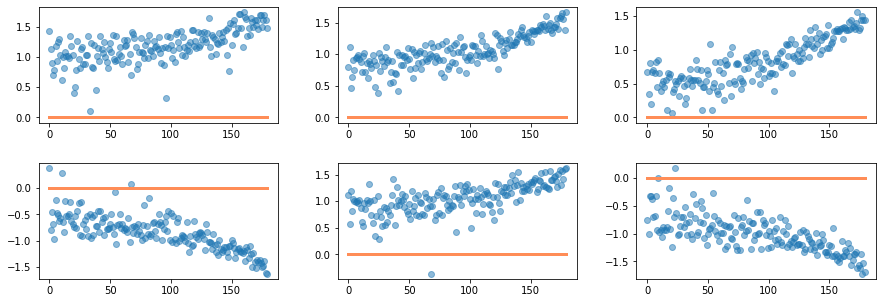

In [13]:
unit_index = 5
predict_sensors(net, X[unit_index], train_data[unit_index], unit_index)

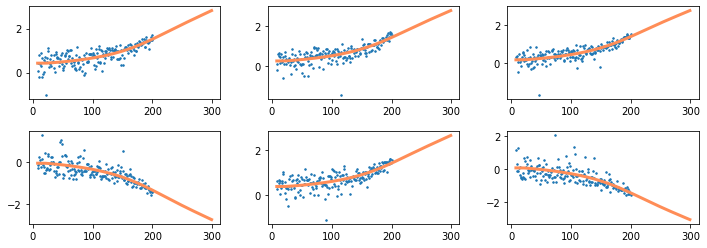

In [15]:
index, valid_len = 8, 300
predict_sensors2(train_data[index], index, valid_len)

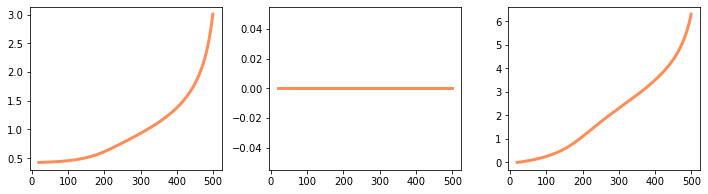

In [16]:
fig = plt.figure(figsize=(12,3))

for i in range(3):
    plt.subplot(1, 3, 1+i)
    t = np.arange(Psi.shape[0])
    plt.plot(t[20:], Psi[20:,i], color='#FF8D57', linewidth = 3)

plt.subplots_adjust(wspace = 0.25, hspace = 0.35)
plt.show()

In [17]:
# 计算传感器噪声方差
sigma2 = np.zeros(num_sensors)

for i in range(num_sensors):
    tmp_sigma2 = 0
    tmp_m = 0
    for j in range(num_train):
        gamma_j = gamma[j,i]
        sensor_data = train_data[j][:,i].detach().numpy()
        tmp_n = lengths[j]
        
        tmp_Psi = Psi[:tmp_n]
        sensor_path = tmp_Psi @ gamma_j
        
        tmp_sigma2 += np.power(sensor_path - sensor_data, 2).sum()
        tmp_m += (tmp_n - 6)
        
    sigma2[i] = tmp_sigma2/tmp_m
sigma2

array([0.08853255, 0.07232826, 0.05926688, 0.05854069, 0.07261152,
       0.08553381])

In [18]:
# gamma的均值和协方差
cov_list = []
for i in range(num_sensors):
    data_i = gamma[:,i]
    cov_i = np.cov(data_i.T)
    cov_list.append(cov_i)
    
cov = block_diag(cov_list[0],cov_list[1],cov_list[2],cov_list[3],cov_list[4],cov_list[5])
mu = gamma.reshape(num_train,-1).mean(axis=0).reshape(-1,1)

cov.shape, mu.shape

((18, 18), (18, 1))

In [19]:
mu_i = np.zeros((num_train, 3*num_sensors,1)) 
cov_i = np.zeros((num_train,3*num_sensors,3*num_sensors))

for i in range(num_train):
    tmp_n = lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = train_data[i].detach().numpy().T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_i[i] = tmp_mu
    cov_i[i] = tmp_cov

In [20]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 25 # 超参数
inputs = np.zeros((K*num_train,2*N,num_sensors))

for i in range(num_train):
    M = lengths[i]
    gamma_samples = np.random.multivariate_normal(mu_i[i].flatten(), cov_i[i], size=K)  
    
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
        
    for k in range(K):
        inputs[i*K+k] = (Psi @ gamma_samples[k].reshape(num_sensors,-1).T)[t]

In [21]:
# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
# print(label.shape) (1,160)
labels = np.repeat(labels, K*num_train, axis=0)
print(labels.shape)

(1000, 160)


In [24]:
# 设置特征值-logistic regression
N, delta, K = 80, 1, 10 # 超参数
inputs = np.zeros((num_train,2*N,num_sensors))
for i in range(num_train):
    M = lengths[i]
    y_pred = Psi @ gamma[i].T
        
    M = lengths[i]
    t = torch.zeros(2*N, dtype=torch.long)
    for j in range(2*N):
        t[j] = M + (j-N+1) * delta
    
    inputs[i] = y_pred[t]

# 设置标签值
labels = np.hstack((np.zeros(N), np.ones(N))).reshape(1,-1)
labels = np.repeat(labels, num_train, axis=0)

In [22]:
inputs.shape, labels.shape

((1000, 160, 6), (1000, 160))

In [70]:
np.save('inputs7.npy',inputs)
np.save('labels7.npy',labels)

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
X_train = inputs.reshape(-1,num_sensors)
Y_train = labels.reshape(-1,1)
X_train.shape, Y_train.shape

((160000, 6), (160000, 1))

In [25]:
model = LogisticRegression(penalty="l2", C=0.05, solver="liblinear", max_iter=1000) #创建模型
model.fit(X_train, Y_train.ravel()) #训练

LogisticRegression(C=0.05, max_iter=1000, solver='liblinear')

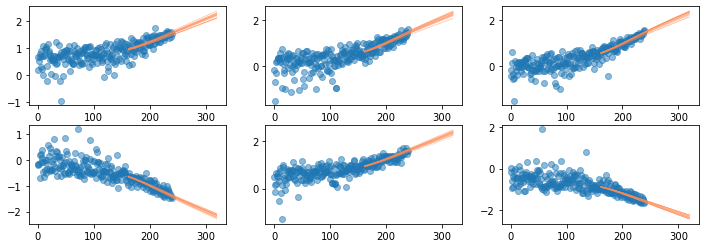

In [26]:
index = 10
sensor_data = train_data[index]

M = lengths[index]
t = torch.zeros(2*N, dtype=torch.long)
for j in range(2*N):
    t[j] = M + (j-N+1) * delta

fig = plt.figure(figsize=(12,4))
for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha=0.5)
    for k in range(K):
        sensor_path = inputs[index*K + k]
        plt.plot(t, sensor_path[:,i], color='#FF8D57', linewidth = 0.2)

In [27]:
df_test = pd.read_csv('test_data.csv')
num_test = df_test['Unit'].max()      # 测试数据数量

test_data = []
test_lengths = []
for i in range(num_test):
    Y = np.array(df_test[df_test['Unit']==i+1].iloc[:,2:]) 
    test_data.append(Y)
    test_lengths.append(len(Y))

In [28]:
mu_j = np.zeros((num_test, num_hiddens*num_sensors,1)) 
cov_j = np.zeros((num_test,num_hiddens*num_sensors,num_hiddens*num_sensors))

for i in range(num_test):
    tmp_n = test_lengths[i]
    tmp_psi = Psi[:tmp_n]
    
    Psi_i = block_diag(tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi,tmp_psi)
    # 构建块对角矩阵
    omega_i = np.diag(np.repeat(sigma2.reshape(-1,1),tmp_n,axis=1).flatten())

    L_i = test_data[i].T.flatten().reshape(-1,1) # n_i*1
    
    # 计算后验分布
    tmp_cov = inv(Psi_i.T @ inv(omega_i) @ Psi_i + inv(cov))
    tmp_mu = tmp_cov @ (Psi_i.T @ inv(omega_i) @ L_i + inv(cov) @ mu)
    
    mu_j[i] = tmp_mu
    cov_j[i] = tmp_cov

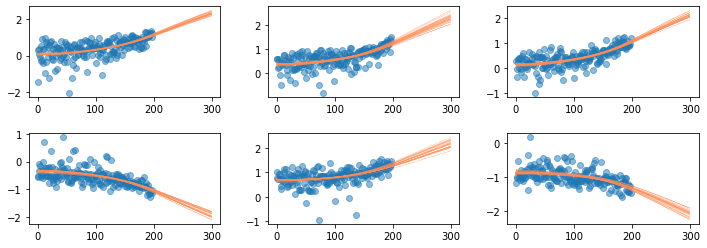

In [29]:
index, K, valid_len = 99, 25, 300
sensor_data = test_data[index]
tmp_Psi = Psi[:valid_len]
gamma_samples = np.random.multivariate_normal(mu_j[index].flatten(), cov_j[index], size=K)

fig = plt.figure(figsize=(12,4))

for i in range(6):
    plt.subplot(2, 3, 1+i)
    plt.plot(sensor_data[:,i], 'o', alpha = 0.5)
    for k in range(K):
        sensor_path = tmp_Psi @ gamma_samples[k].reshape(num_sensors,-1).T
        plt.plot(sensor_path[:,i], color='#FF8D57', linewidth=0.3)
        
plt.subplots_adjust(wspace = 0.25, hspace = 0.4)
plt.show()

In [30]:
# 设置特征值
valid_len, K = 500, 25
X_test = np.zeros((num_test, K, valid_len, num_sensors))
for i in range(num_test):
    gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
    for k in range(K):
        X_test[i,k] = Psi[:valid_len] @ gamma_samples[k].reshape(num_sensors,-1).T

In [31]:
X_test.shape

(100, 25, 500, 6)

In [167]:
np.save('X_test7.npy',X_test)

In [32]:
pred_RUL = np.zeros(num_test)
length = np.zeros(num_test)
for i in range(num_test):
    p = np.zeros((K, Psi.shape[0]))
    for k in range(K):
        # sensor_path = Psi @ gamma_samples[k].reshape(7,-1).T
        # features = np.hstack((sensor_path,np.ones((sensor_path.shape[0],1)))).T
        features_i = X_test[i,k]
        p[k] = model.predict_proba(features_i)[:,1]
    pp = np.sum(p,axis=0)/K
    tmp_len = test_lengths[i]
    p_T = (pp - pp[tmp_len])/(1 - pp[tmp_len])
    pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_len
    length[i] = tmp_len

In [34]:
df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
df_RUL['pred_RUL'] = pred_RUL
df_RUL['lifetime'] = df_RUL['true_RUL'] + length
df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
df_RUL['error'].mean()

0.07229117755444642

In [35]:
results = np.zeros(50)
for l in range(50):
    # 设置特征值
    K = 25 # 超参数
    X_test = np.zeros((num_test, K, Psi.shape[0], num_sensors))
    for i in range(num_test):
        gamma_samples = np.random.multivariate_normal(mu_j[i].flatten(), cov_j[i], size=K)    
        for k in range(K):
            X_test[i,k] = Psi @ gamma_samples[k].reshape(num_sensors,-1).T
            
    pred_RUL = np.zeros(num_test)

    for i in range(num_test):
        p = np.zeros((K, Psi.shape[0]))
        for k in range(K):
            x_i = X_test[i,k]
            p[k] = model.predict_proba(x_i)[:,1]
        pp = p.mean(axis=0)
        tmp_n = test_lengths[i]
        p_T = (pp - pp[tmp_n])/(1 - pp[tmp_n])
        pred_RUL[i] = np.where(p_T > 0.5)[0][0] - tmp_n
        
    df_RUL = pd.read_csv('RUL_FD001.txt',names=['true_RUL'])
    df_RUL['pred_RUL'] = pred_RUL
    df_RUL['lifetime'] = df_RUL['true_RUL'] + test_lengths
    df_RUL['error'] = np.abs(df_RUL['true_RUL']-df_RUL['pred_RUL'])/df_RUL['lifetime']
    results[l] = df_RUL['error'].mean()

In [36]:
results.min(),results.mean(), results.std()

(0.06848298615628791, 0.07060841801690493, 0.0009556366727424527)

In [37]:
results.max()

0.0729530075230652